# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [108]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [109]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [110]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [111]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [112]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [113]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [114]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [115]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [116]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [117]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [118]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [119]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [120]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [121]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [122]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [123]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [124]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [125]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [126]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [127]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [128]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [129]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████| 348260/348260 [07:16<00:00, 798.70it/s]


In [130]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [131]:
## Similartly you can do preprocessing for review summary also.

In [132]:
from sklearn.model_selection import train_test_split

data_Linear_SVM = preprocessed_reviews[:100000]
scores_Linear_SVM = final['Score'][:100000]

data_RBF_SVM = preprocessed_reviews[:40000]
scores_RBF_SVM = final['Score'][:40000]

data_train_Linear_SVM,data_test_Linear_SVM,scores_train_Linear_SVM,scores_test_Linear_SVM = train_test_split(data_Linear_SVM, scores_Linear_SVM, test_size=0.2, random_state=1,shuffle = False)
data_train_Linear_SVM,data_cv_Linear_SVM,scores_train_Linear_SVM,scores_cv_Linear_SVM = train_test_split(data_train_Linear_SVM, scores_train_Linear_SVM, test_size=0.25, random_state=1,shuffle = False)

data_train_RBF_SVM,data_test_RBF_SVM,scores_train_RBF_SVM,scores_test_RBF_SVM = train_test_split(data_RBF_SVM, scores_RBF_SVM, test_size=0.2, random_state=1,shuffle = False)
data_train_RBF_SVM,data_cv_RBF_SVM,scores_train_RBF_SVM,scores_cv_RBF_SVM = train_test_split(data_train_RBF_SVM, scores_train_RBF_SVM, test_size=0.25, random_state=1,shuffle = False)

print("Length of data_train_Linear_SVM : ",len(data_train_Linear_SVM))
print("Length of data_cv_Linear_SVM : ",len(data_cv_Linear_SVM))
print("Length of data_test_Linear_SVM : ",len(data_test_Linear_SVM))
print("Length of scores_train_Linear_SVM : ",len(scores_train_Linear_SVM))
print("Length of scores_cv_Linear_SVM : ",len(scores_cv_Linear_SVM))
print("Length of scores_test_Linear_SVM : ",len(scores_test_Linear_SVM))
print("Length of data_train_RBF_SVM : ",len(data_train_RBF_SVM))
print("Length of data_cv_RBF_SVM : ",len(data_cv_RBF_SVM))
print("Length of data_test_RBF_SVM : ",len(data_test_RBF_SVM))
print("Length of scores_train_RBF_SVM : ",len(scores_train_RBF_SVM))
print("Length of scores_cv_RBF_SVM : ",len(scores_cv_RBF_SVM))
print("Length of scores_test_RBF_SVM : ",len(scores_test_RBF_SVM))


Length of data_train_Linear_SVM :  60000
Length of data_cv_Linear_SVM :  20000
Length of data_test_Linear_SVM :  20000
Length of scores_train_Linear_SVM :  60000
Length of scores_cv_Linear_SVM :  20000
Length of scores_test_Linear_SVM :  20000
Length of data_train_RBF_SVM :  24000
Length of data_cv_RBF_SVM :  8000
Length of data_test_RBF_SVM :  8000
Length of scores_train_RBF_SVM :  24000
Length of scores_cv_RBF_SVM :  8000
Length of scores_test_RBF_SVM :  8000


# [4] Featurization

## [4.1] BAG OF WORDS

In [133]:
#BoW
#Linear SVM
bow_count_vect_Linear_SVM = CountVectorizer() #in scikit-learn
bow_count_vect_Linear_SVM.fit(data_train_Linear_SVM)
bow_train_Linear_SVM = bow_count_vect_Linear_SVM.fit_transform(data_train_Linear_SVM)
bow_cv_Linear_SVM = bow_count_vect_Linear_SVM.transform(data_cv_Linear_SVM)
bow_test_Linear_SVM = bow_count_vect_Linear_SVM.transform(data_test_Linear_SVM)

#RBF SVM
count_vect = CountVectorizer(min_df=10,max_features=500)
count_vect.fit(data_train_RBF_SVM)
bow_train_RBF_SVM = count_vect.fit_transform(data_train_RBF_SVM)
bow_cv_RBF_SVM = count_vect.transform(data_cv_RBF_SVM)
bow_test_RBF_SVM = count_vect.transform(data_test_RBF_SVM)

## [4.2] TF-IDF

In [134]:
#TF-IDF
#Linear SVM
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(data_train_Linear_SVM)
tf_idf_train_Linear_SVM = tf_idf_vect.fit_transform(data_train_Linear_SVM)
tf_idf_cv_Linear_SVM = tf_idf_vect.transform(data_cv_Linear_SVM)
tf_idf_test_Linear_SVM = tf_idf_vect.transform(data_test_Linear_SVM)

#RBF SVM
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect.fit(data_train_RBF_SVM)
tf_idf_train_RBF_SVM = tf_idf_vect.fit_transform(data_train_RBF_SVM)
tf_idf_cv_RBF_SVM = tf_idf_vect.transform(data_cv_RBF_SVM)
tf_idf_test_RBF_SVM = tf_idf_vect.transform(data_test_RBF_SVM)


## [4.3] Word2Vec

In [135]:
# Train your own Word2Vec model using your own text corpus
# Linear SVM
X_train_Linear_SVM = []
for i in data_train_Linear_SVM:
    X_train_Linear_SVM.append(i.split())

w2v_model_Linear_SVM=Word2Vec(X_train_Linear_SVM,min_count=5,size=50, workers=4)
w2v_words_Linear_SVM = list(w2v_model_Linear_SVM.wv.vocab)

# RBF SVM
X_train_RBF_SVM = []
for i in data_train_RBF_SVM:
    X_train_RBF_SVM.append(i.split())

w2v_model_RBF_SVM=Word2Vec(X_train_RBF_SVM,min_count=5,size=50, workers=4)
w2v_words_RBF_SVM = list(w2v_model_RBF_SVM.wv.vocab)


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [136]:
def avg_W2V(list_of_sentance,w2v_model,w2v_words):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

# Linear SVM
avgw2v_train_Linear_SVM = avg_W2V(data_train_Linear_SVM,w2v_model_Linear_SVM,w2v_words_Linear_SVM)
avgw2v_cv_Linear_SVM = avg_W2V(data_cv_Linear_SVM,w2v_model_Linear_SVM,w2v_words_Linear_SVM)
avgw2v_test_Linear_SVM = avg_W2V(data_test_Linear_SVM,w2v_model_Linear_SVM,w2v_words_Linear_SVM)

# RBF SVM
avgw2v_train_RBF_SVM = avg_W2V(data_train_RBF_SVM,w2v_model_RBF_SVM,w2v_words_RBF_SVM)
avgw2v_cv_RBF_SVM = avg_W2V(data_cv_RBF_SVM,w2v_model_RBF_SVM,w2v_words_RBF_SVM)
avgw2v_test_RBF_SVM = avg_W2V(data_test_RBF_SVM,w2v_model_RBF_SVM,w2v_words_RBF_SVM)

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:44<00:00, 180.36it/s]


#### [4.3.1.2] TFIDF weighted W2v

In [137]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# Linear SVM
model_Linear_SVM = TfidfVectorizer()
tf_idf_matrix_Linear_SVM = model_Linear_SVM.fit_transform(data_train_Linear_SVM)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_Linear_SVM = dict(zip(model_Linear_SVM.get_feature_names(), list(model_Linear_SVM.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat_Linear_SVM = model_Linear_SVM.get_feature_names() # tfidf words/col-names

# RBF SVM
model_RBF_SVM = TfidfVectorizer()
tf_idf_matrix_RBF_SVM = model_RBF_SVM.fit_transform(data_train_RBF_SVM)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_RBF_SVM = dict(zip(model_RBF_SVM.get_feature_names(), list(model_RBF_SVM.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat_RBF_SVM = model_RBF_SVM.get_feature_names() # tfidf words/col-names


In [138]:

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tf_idf_w2v(list_of_sentance,w2v_model,w2v_words,tfidf_feat,dictionary):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        
    return tfidf_sent_vectors

# Linear SVM
tf_idf_w2v_train_Linear_SVM = tf_idf_w2v(data_train_Linear_SVM,w2v_model_Linear_SVM,w2v_words_Linear_SVM,tfidf_feat_Linear_SVM,dictionary_Linear_SVM)
tf_idf_w2v_cv_Linear_SVM = tf_idf_w2v(data_cv_Linear_SVM,w2v_model_Linear_SVM,w2v_words_Linear_SVM,tfidf_feat_Linear_SVM,dictionary_Linear_SVM)
tf_idf_w2v_test_Linear_SVM = tf_idf_w2v(data_test_Linear_SVM,w2v_model_Linear_SVM,w2v_words_Linear_SVM,tfidf_feat_Linear_SVM,dictionary_Linear_SVM)

# RBF SVM
tf_idf_w2v_train_RBF_SVM = tf_idf_w2v(data_train_RBF_SVM,w2v_model_RBF_SVM,w2v_words_RBF_SVM,tfidf_feat_RBF_SVM,dictionary_RBF_SVM)
tf_idf_w2v_cv_RBF_SVM = tf_idf_w2v(data_cv_RBF_SVM,w2v_model_RBF_SVM,w2v_words_RBF_SVM,tfidf_feat_RBF_SVM,dictionary_RBF_SVM)
tf_idf_w2v_test_RBF_SVM = tf_idf_w2v(data_test_RBF_SVM,w2v_model_RBF_SVM,w2v_words_RBF_SVM,tfidf_feat_RBF_SVM,dictionary_RBF_SVM)


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [09:49<00:00, 13.56it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

In [139]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

def get_AUC(X_train,y_train,X_cv,y_cv,alpha,penalty):
    """This function apply SGDClassifier with 'hinge' loss 
        on train and cv data and return AUC values for train and cross validation"""
    auc_train = []
    auc_cv = []
    # applying SGDClassifier on list of hyper parameters to find best alpha using simple loop
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty=penalty, loss='hinge', random_state=42,class_weight='balanced')
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        prob_train = sig_clf.predict_proba(X_train)
        fpr, tpr, threshold = roc_curve(y_train, prob_train[:, 1])
        auc_train.append(auc(fpr,tpr))
        
        prob_cv = sig_clf.predict_proba(X_cv)
        fpr, tpr, threshold = roc_curve(y_cv, prob_cv[:, 1])
        auc_cv.append(auc(fpr,tpr))   
       
    return auc_train,auc_cv

def plot_AUC_Curves(auc_train,auc_cv,alpha,title):
    """This function plots the auc curves for the given auc values and alpha"""
    sns.set_style("whitegrid",{'axes.grid' : False})
    plt.plot(np.log(alpha),auc_train,"b-",label = "AUC_Train")
    plt.plot(np.log(alpha),auc_cv,"r-",label = "AUC_Validation")
    plt.scatter(np.log(alpha),auc_train)
    plt.scatter(np.log(alpha),auc_cv)
    plt.legend()
    plt.xlabel("Hyper Parameter")
    plt.ylabel("AUC")
    plt.title(title)
    plt.show()
    
def apply_roc_curve(X_train,y_train,X_test,y_test,optimal_alpha,penalty):
    """This function apply SGDClassifier model on train and predict labels for test data 
       and also find FPR and TPR for train and test data.
       Returns the predicted labels,FPR and TPR values"""
    clf = SGDClassifier(alpha = optimal_alpha,penalty = penalty,loss = 'hinge',random_state = 42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    prob_train = sig_clf.predict_proba(X_train)
    fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train[:, 1])
    prob_test = sig_clf.predict_proba(X_test)
    fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test[:, 1])
    
    # predict the class labels
    pred_train = sig_clf.predict(X_train)
    pred_test = sig_clf.predict(X_test)
    w = clf.coef_
    return fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test,w
    
def plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test):
    """This function plot the roc curves for train and test data"""
    # plot ROC curves for train and test data
    plt.plot(fpr_train,tpr_train,"g-",label = "AUC_Train : "+str(auc(fpr_train, tpr_train)))
    plt.plot(fpr_test,tpr_test,"r-",label = "AUC_Test : "+str(auc(fpr_test, tpr_test)))
    plt.plot([0,1],[0,1],"b-")
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
def plot_Confusion_Matrix(actual_labels,predict_labels,title):
    """This function plot the confusion matrix"""
    # Reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cm = confusion_matrix(actual_labels, predict_labels)
    classNames = ['NO','YES']
    cm_data = pd.DataFrame(cm,index = classNames,
                  columns = classNames)
    plt.figure(figsize = (5,4))
    sns.heatmap(cm_data, annot=True,fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()



### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

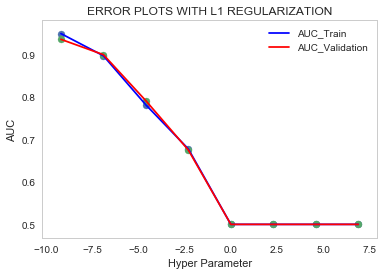

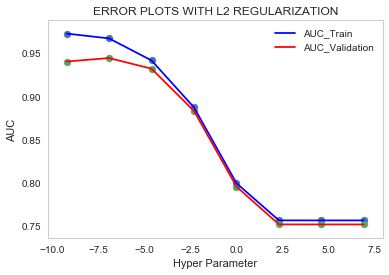

In [140]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc with 'l1' regularization
auc_train_l1,auc_cv_l1 = get_AUC(bow_train_Linear_SVM,scores_train_Linear_SVM,bow_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l1')
# apply auc with 'l2' regularization
auc_train_l2,auc_cv_l2 = get_AUC(bow_train_Linear_SVM,scores_train_Linear_SVM,bow_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l2')

# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS WITH L1 REGULARIZATION')
plot_AUC_Curves(auc_train_l2,auc_cv_l2,alpha,'ERROR PLOTS WITH L2 REGULARIZATION')



In [141]:
# Optimal alpha
optimal_alpha_l1 = alpha[auc_cv_l1.index(max(auc_cv_l1))]
optimal_alpha_l2 = alpha[auc_cv_l2.index(max(auc_cv_l2))]
optimal_alpha_bow_Linear_SVM = 0
penalty_bow_Linear_SVM = 'l1'
if(optimal_alpha_l1>=optimal_alpha_l2):
    optimal_alpha_bow_Linear_SVM = optimal_alpha_l1
    penalty_bow_Linear_SVM = 'l1'
else:
    optimal_alpha_bow_Linear_SVM = optimal_alpha_l2
    penalty_bow_Linear_SVM = 'l2'
    
print('Optimal_alpha : ',optimal_alpha_bow_Linear_SVM)
print('Regularization : ',penalty_bow_Linear_SVM)

Optimal_alpha :  0.001
Regularization :  l2


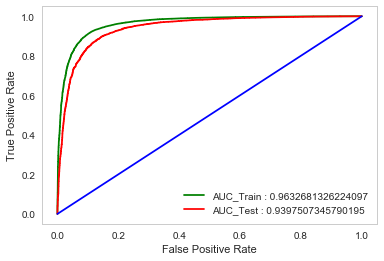

AUC :  0.9397507345790195


In [142]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test,weights_bow = apply_roc_curve(bow_train_Linear_SVM,scores_train_Linear_SVM,bow_test_Linear_SVM,scores_test_Linear_SVM,optimal_alpha_bow_Linear_SVM,penalty_bow_Linear_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_bow_Linear_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_bow_Linear_SVM)


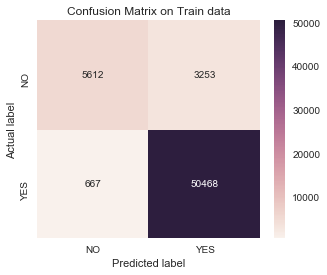

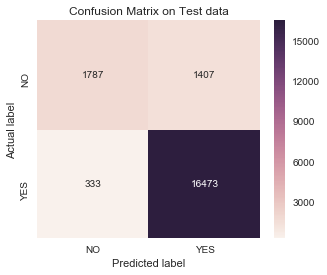

In [143]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_Linear_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_Linear_SVM,pred_test,"Confusion Matrix on Test data")


#### Top 10 important features of positive class from<font color='red'> SET 1</font>

In [144]:
weights = weights_bow[0,:]
top10_positive_indices = list(weights.argsort()[-10:])
top10_positive_indices.reverse()
rank = np.array(range(1,11))
top10_positive_features = np.take(bow_count_vect_Linear_SVM.get_feature_names(),top10_positive_indices)
prob = np.take(weights,top10_positive_indices)
top10_positive_features_details = pd.DataFrame(data = {'Rank' : rank,'Feature' : top10_positive_features,'Probability' : prob})
print(top10_positive_features_details)

     Feature  Probability  Rank
0  excellent     0.599647     1
1  delicious     0.582990     2
2      loves     0.569664     3
3      great     0.569664     4
4    perfect     0.516362     5
5     highly     0.503037     6
6    pleased     0.489711     7
7       best     0.489711     8
8    awesome     0.486380     9
9    amazing     0.433078    10


#### Top 10 important features of negative class from<font color='red'> SET 1</font>

In [145]:
weights = weights_bow[0,:]
top10_neg_indices = list(weights.argsort()[:10])
rank = np.array(range(1,11))
top10_negative_features = np.take(bow_count_vect_Linear_SVM.get_feature_names(),top10_neg_indices)
prob = np.take(weights,top10_neg_indices)
top10_negative_features_details = pd.DataFrame(data = {'Rank' : rank,'Feature' : top10_negative_features,'Probability' : prob})
print(top10_negative_features_details)

          Feature  Probability  Rank
0           worst    -0.996080     1
1   disappointing    -0.879482     2
2        terrible    -0.819517     3
3    disappointed    -0.789535     4
4           threw    -0.746227     5
5           awful    -0.709582     6
6  disappointment    -0.699588     7
7        horrible    -0.666274     8
8   unfortunately    -0.599647     9
9          return    -0.586321    10


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

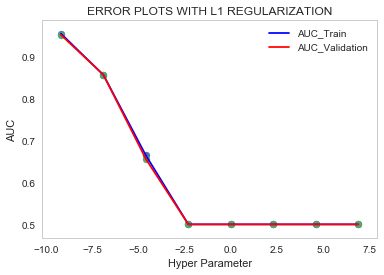

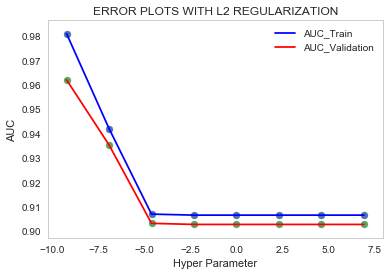

In [146]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc with 'l1' regularization
auc_train_l1,auc_cv_l1 = get_AUC(tf_idf_train_Linear_SVM,scores_train_Linear_SVM,tf_idf_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l1')
# apply auc with 'l2' regularization
auc_train_l2,auc_cv_l2 = get_AUC(tf_idf_train_Linear_SVM,scores_train_Linear_SVM,tf_idf_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l2')

# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS WITH L1 REGULARIZATION')
plot_AUC_Curves(auc_train_l2,auc_cv_l2,alpha,'ERROR PLOTS WITH L2 REGULARIZATION')



In [147]:
# Optimal alpha
optimal_alpha_l1 = alpha[auc_cv_l1.index(max(auc_cv_l1))]
optimal_alpha_l2 = alpha[auc_cv_l2.index(max(auc_cv_l2))]
optimal_alpha_tf_idf_Linear_SVM = 0
penalty_tf_idf_Linear_SVM = 'l1'
if(optimal_alpha_l1>=optimal_alpha_l2):
    optimal_alpha_tf_idf_Linear_SVM = optimal_alpha_l1
    penalty_tf_idf_Linear_SVM = 'l1'
else:
    optimal_alpha_tf_idf_Linear_SVM = optimal_alpha_l2
    penalty_tf_idf_Linear_SVM = 'l2'
    
print('Optimal_alpha : ',optimal_alpha_tf_idf_Linear_SVM)
print('Regularization : ',penalty_tf_idf_Linear_SVM)

Optimal_alpha :  0.0001
Regularization :  l1


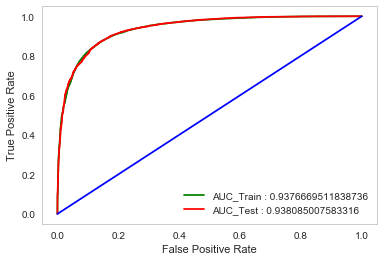

AUC :  0.938085007583316


In [148]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test,weights_tf_idf = apply_roc_curve(tf_idf_train_Linear_SVM,scores_train_Linear_SVM,tf_idf_test_Linear_SVM,scores_test_Linear_SVM,optimal_alpha_tf_idf_Linear_SVM,penalty_tf_idf_Linear_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_tf_idf_Linear_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_tf_idf_Linear_SVM)


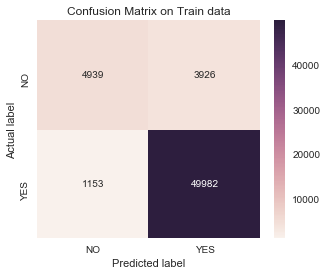

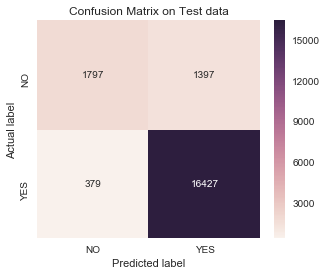

In [149]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_Linear_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_Linear_SVM,pred_test,"Confusion Matrix on Test data")


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

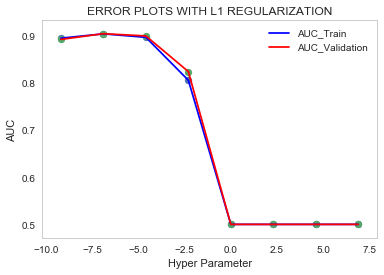

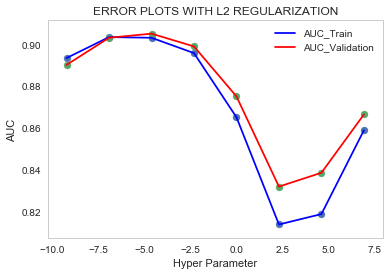

In [150]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc with 'l1' regularization
auc_train_l1,auc_cv_l1 = get_AUC(avgw2v_train_Linear_SVM,scores_train_Linear_SVM,avgw2v_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l1')
# apply auc with 'l2' regularization
auc_train_l2,auc_cv_l2 = get_AUC(avgw2v_train_Linear_SVM,scores_train_Linear_SVM,avgw2v_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l2')

# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS WITH L1 REGULARIZATION')
plot_AUC_Curves(auc_train_l2,auc_cv_l2,alpha,'ERROR PLOTS WITH L2 REGULARIZATION')



In [151]:
# Optimal alpha
optimal_alpha_l1 = alpha[auc_cv_l1.index(max(auc_cv_l1))]
optimal_alpha_l2 = alpha[auc_cv_l2.index(max(auc_cv_l2))]
optimal_alpha_avgw2v_Linear_SVM = 0
penalty_avgw2v_Linear_SVM = 'l1'
if(optimal_alpha_l1>=optimal_alpha_l2):
    optimal_alpha_avgw2v_Linear_SVM = optimal_alpha_l1
    penalty_avgw2v_Linear_SVM = 'l1'
else:
    optimal_alpha_avgw2v_Linear_SVM = optimal_alpha_l2
    penalty_avgw2v_Linear_SVM = 'l2'
    
print('Optimal_alpha : ',optimal_alpha_avgw2v_Linear_SVM)
print('Regularization : ',penalty_avgw2v_Linear_SVM)

Optimal_alpha :  0.01
Regularization :  l2


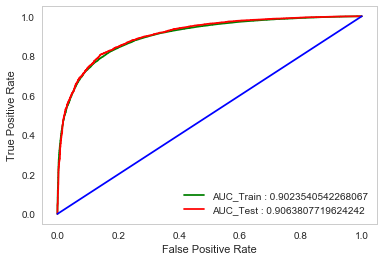

AUC :  0.9063807719624242


In [152]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test,weights_avgw2v = apply_roc_curve(avgw2v_train_Linear_SVM,scores_train_Linear_SVM,avgw2v_test_Linear_SVM,scores_test_Linear_SVM,optimal_alpha_avgw2v_Linear_SVM,penalty_avgw2v_Linear_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_avgw2v_Linear_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_avgw2v_Linear_SVM)


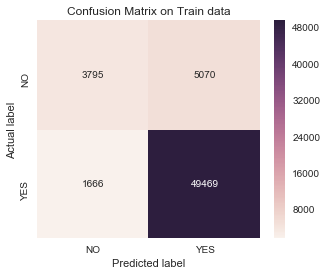

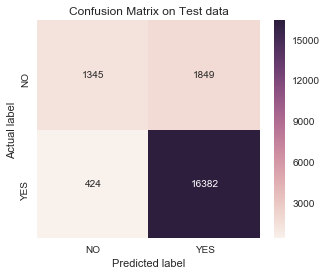

In [153]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_Linear_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_Linear_SVM,pred_test,"Confusion Matrix on Test data")


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

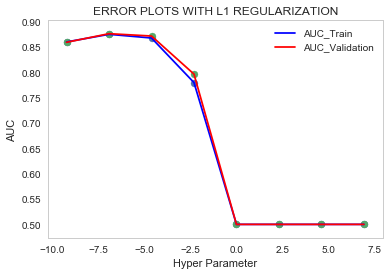

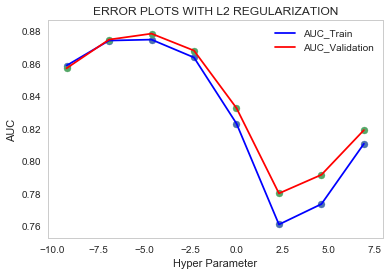

In [154]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc with 'l1' regularization
auc_train_l1,auc_cv_l1 = get_AUC(tf_idf_w2v_train_Linear_SVM,scores_train_Linear_SVM,tf_idf_w2v_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l1')
# apply auc with 'l2' regularization
auc_train_l2,auc_cv_l2 = get_AUC(tf_idf_w2v_train_Linear_SVM,scores_train_Linear_SVM,tf_idf_w2v_cv_Linear_SVM,scores_cv_Linear_SVM,alpha,'l2')

# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS WITH L1 REGULARIZATION')
plot_AUC_Curves(auc_train_l2,auc_cv_l2,alpha,'ERROR PLOTS WITH L2 REGULARIZATION')



In [155]:
# Optimal alpha
optimal_alpha_l1 = alpha[auc_cv_l1.index(max(auc_cv_l1))]
optimal_alpha_l2 = alpha[auc_cv_l2.index(max(auc_cv_l2))]
optimal_alpha_tf_idf_w2v_Linear_SVM = 0
penalty_tf_idf_w2v_Linear_SVM = 'l1'
if(optimal_alpha_l1>=optimal_alpha_l2):
    optimal_alpha_tf_idf_w2v_Linear_SVM = optimal_alpha_l1
    penalty_tf_idf_w2v_Linear_SVM = 'l1'
else:
    optimal_alpha_tf_idf_w2v_Linear_SVM = optimal_alpha_l2
    penalty_tf_idf_w2v_Linear_SVM = 'l2'
    
print('Optimal_alpha : ',optimal_alpha_tf_idf_w2v_Linear_SVM)
print('Regularization : ',penalty_tf_idf_w2v_Linear_SVM)

Optimal_alpha :  0.01
Regularization :  l2


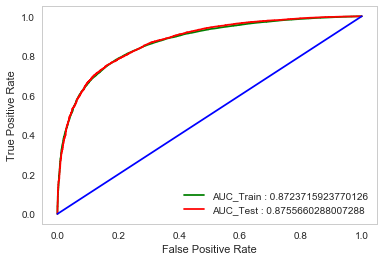

AUC :  0.8755660288007288


In [156]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test,weights_tf_idf_w2v = apply_roc_curve(tf_idf_w2v_train_Linear_SVM,scores_train_Linear_SVM,tf_idf_w2v_test_Linear_SVM,scores_test_Linear_SVM,optimal_alpha_tf_idf_w2v_Linear_SVM,penalty_tf_idf_w2v_Linear_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_tf_idf_w2v_Linear_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_tf_idf_w2v_Linear_SVM)


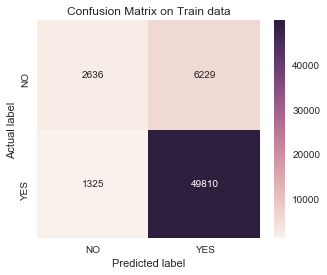

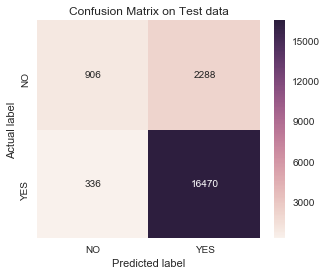

In [157]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_Linear_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_Linear_SVM,pred_test,"Confusion Matrix on Test data")


## [5.2] RBF SVM

In [158]:
from sklearn.svm import SVC

def get_AUC_RBF(X_train,y_train,X_cv,y_cv,alpha):
    """This function apply SGDClassifier with 'RBF' loss 
        on train and cv data and return AUC values for train and cross validation"""
    auc_train = []
    auc_cv = []
    # applying SGDClassifier on list of hyper parameters to find best alpha using simple loop
    for i in alpha:
        clf = SVC(C=i, kernel='rbf', random_state=42,class_weight='balanced',probability=True)
        clf.fit(X_train, y_train)
        prob_train = clf.predict_proba(X_train)
        fpr, tpr, threshold = roc_curve(y_train, prob_train[:, 1])
        auc_train.append(auc(fpr,tpr))
        
        prob_cv = clf.predict_proba(X_cv)
        fpr, tpr, threshold = roc_curve(y_cv, prob_cv[:, 1])
        auc_cv.append(auc(fpr,tpr))   
       
    return auc_train,auc_cv
  
def apply_roc_curve_RBF(X_train,y_train,X_test,y_test,optimal_alpha):
    """This function apply SGDClassifier model on train and predict labels for test data 
       and also find FPR and TPR for train and test data.
       Returns the predicted labels,FPR and TPR values"""
    clf = SVC(C = optimal_alpha,kernel = 'rbf',random_state = 42,probability=True)
    clf.fit(X_train,y_train)
    prob_train = clf.predict_proba(X_train)
    fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train[:, 1])
    prob_test = clf.predict_proba(X_test)
    fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test[:, 1])
    
    # predict the class labels
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    #w = clf.coef_
    return fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test
    

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

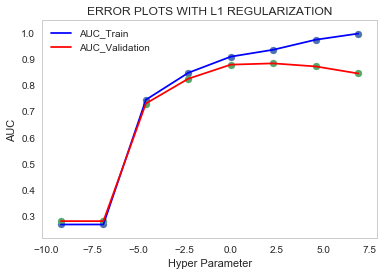

In [159]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc with 'l1' regularization
auc_train_l1,auc_cv_l1 = get_AUC_RBF(bow_train_RBF_SVM,scores_train_RBF_SVM,bow_cv_RBF_SVM,scores_cv_RBF_SVM,alpha)
# apply auc with 'l2' regularization
#auc_train_l2,auc_cv_l2 = get_AUC_RBF(bow_train_RBF_SVM,scores_train_RBF_SVM,bow_cv_RBF_SVM,scores_cv_RBF_SVM,alpha)

# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS WITH L1 REGULARIZATION')
#plot_AUC_Curves(auc_train_l2,auc_cv_l2,alpha,'ERROR PLOTS WITH L2 REGULARIZATION')



In [160]:
# Optimal alpha
optimal_alpha_l1 = alpha[auc_cv_l1.index(max(auc_cv_l1))]
optimal_alpha_l2 = alpha[auc_cv_l2.index(max(auc_cv_l2))]
optimal_alpha_bow_RBF_SVM = 0
penalty_bow_RBF_SVM = 'l1'
if(optimal_alpha_l1>=optimal_alpha_l2):
    optimal_alpha_bow_RBF_SVM = optimal_alpha_l1
    penalty_bow_RBF_SVM = 'l1'
else:
    optimal_alpha_bow_RBF_SVM = optimal_alpha_l2
    penalty_bow_RBF_SVM = 'l2'
    
print('Optimal_alpha : ',optimal_alpha_bow_RBF_SVM)
print('Regularization : ',penalty_bow_RBF_SVM)

Optimal_alpha :  10
Regularization :  l1


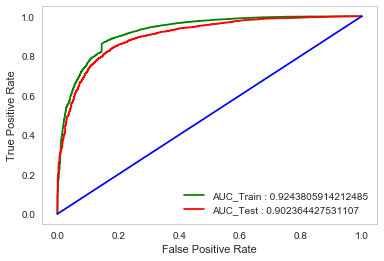

AUC :  0.902364427531107


In [161]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test = apply_roc_curve_RBF(bow_train_RBF_SVM,scores_train_RBF_SVM,bow_test_RBF_SVM,scores_test_RBF_SVM,optimal_alpha_bow_RBF_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_bow_RBF_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_bow_RBF_SVM)


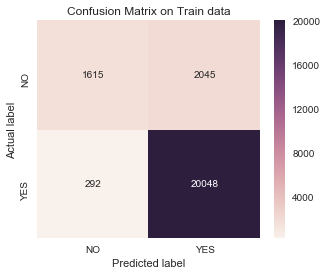

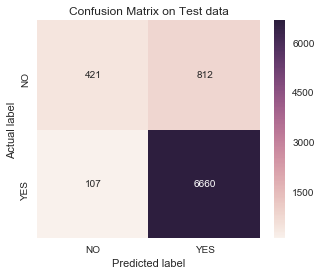

In [162]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_RBF_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_RBF_SVM,pred_test,"Confusion Matrix on Test data")

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

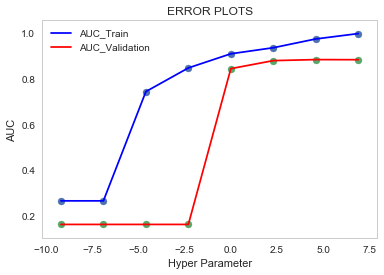

In [163]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc 
auc_train,auc_cv = get_AUC_RBF(tf_idf_train_RBF_SVM,scores_train_RBF_SVM,tf_idf_cv_RBF_SVM,scores_cv_RBF_SVM,alpha)
# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv,alpha,'ERROR PLOTS')


In [164]:
# Optimal alpha
optimal_alpha_tf_idf_RBF_SVM = alpha[auc_cv_l1.index(max(auc_cv_l1))]
print('Optimal_alpha : ',optimal_alpha_tf_idf_RBF_SVM)

Optimal_alpha :  10


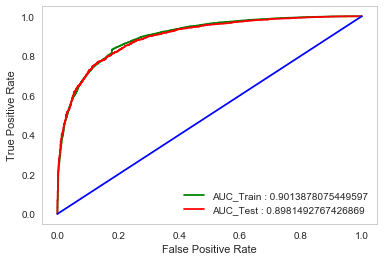

AUC :  0.8981492767426869


In [165]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test = apply_roc_curve_RBF(tf_idf_train_RBF_SVM,scores_train_RBF_SVM,tf_idf_test_RBF_SVM,scores_test_RBF_SVM,optimal_alpha_tf_idf_RBF_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_tf_idf_RBF_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_tf_idf_RBF_SVM)


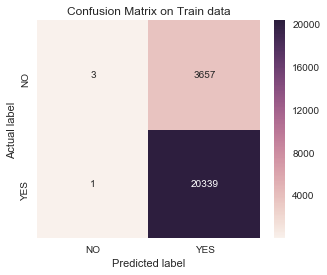

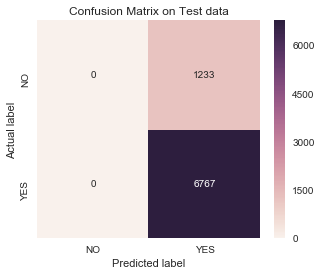

In [166]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_RBF_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_RBF_SVM,pred_test,"Confusion Matrix on Test data")

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

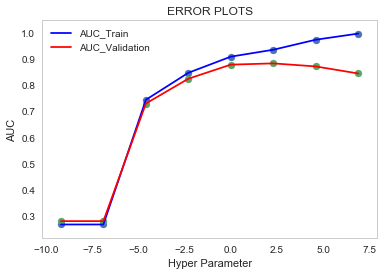

In [167]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc
auc_train,auc_cv = get_AUC_RBF(avgw2v_train_RBF_SVM,scores_train_RBF_SVM,avgw2v_cv_RBF_SVM,scores_cv_RBF_SVM,alpha)
# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS')

In [168]:
# Optimal alpha
optimal_alpha_avgw2v_RBF_SVM = alpha[auc_cv.index(max(auc_cv))]
print('Optimal_alpha : ',optimal_alpha_avgw2v_RBF_SVM)

Optimal_alpha :  10


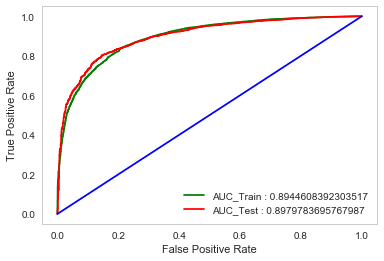

AUC :  0.8979783695767987


In [169]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test = apply_roc_curve_RBF(avgw2v_train_RBF_SVM,scores_train_RBF_SVM,avgw2v_test_RBF_SVM,scores_test_RBF_SVM,optimal_alpha_avgw2v_RBF_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_avgw2v_RBF_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_avgw2v_RBF_SVM)

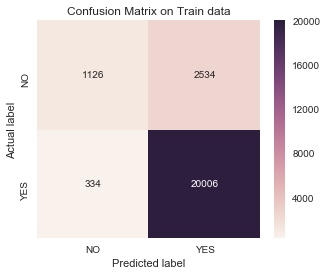

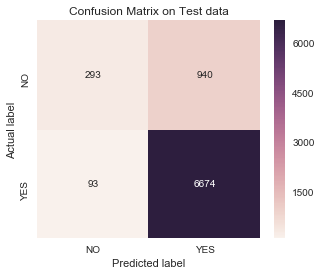

In [170]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_RBF_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_RBF_SVM,pred_test,"Confusion Matrix on Test data")

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

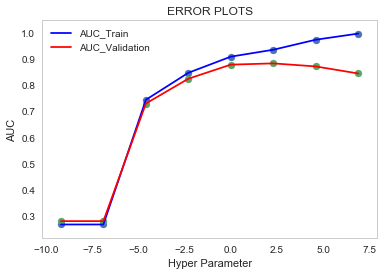

In [171]:
# alpha
alpha = [10 ** x for x in range(-4,4)]
# apply auc
auc_train,auc_cv = get_AUC_RBF(tf_idf_w2v_train_RBF_SVM,scores_train_RBF_SVM,tf_idf_w2v_cv_RBF_SVM,scores_cv_RBF_SVM,alpha)
# plot AUC curves for train and cross validation data
plot_AUC_Curves(auc_train_l1,auc_cv_l1,alpha,'ERROR PLOTS')

In [172]:
# Optimal alpha
optimal_alpha_tf_idf_w2v_RBF_SVM = alpha[auc_cv.index(max(auc_cv))]
print('Optimal_alpha : ',optimal_alpha_tf_idf_w2v_RBF_SVM)

Optimal_alpha :  100


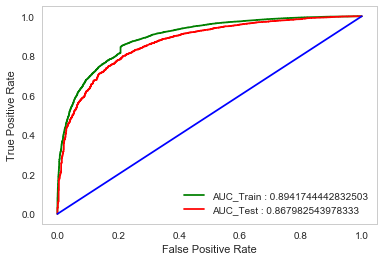

AUC :  0.867982543978333


In [173]:
# roc
fpr_train,tpr_train,fpr_test,tpr_test,pred_train,pred_test = apply_roc_curve_RBF(tf_idf_w2v_train_RBF_SVM,scores_train_RBF_SVM,tf_idf_w2v_test_RBF_SVM,scores_test_RBF_SVM,optimal_alpha_tf_idf_w2v_RBF_SVM)

# plot roc
plot_roc_curve(fpr_train,tpr_train,fpr_test,tpr_test)

# auc for bow
auc_tf_idf_w2v_RBF_SVM = auc(fpr_test,tpr_test)
print('AUC : ',auc_tf_idf_w2v_RBF_SVM)

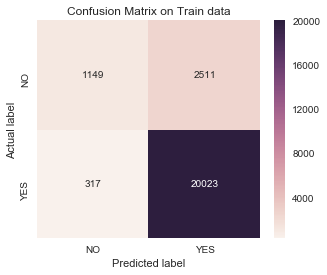

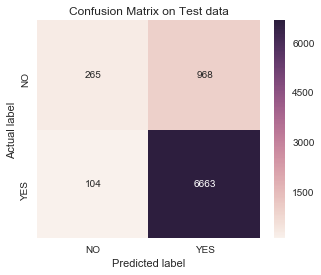

In [174]:
# Confusion matrix
plot_Confusion_Matrix(scores_train_RBF_SVM,pred_train,"Confusion Matrix on Train data")
plot_Confusion_Matrix(scores_test_RBF_SVM,pred_test,"Confusion Matrix on Test data")

# [6] Conclusions

In [175]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

linearSVM_table = PrettyTable()
linearSVM_table.field_names = ["Vectorizer","Regularization","Hyper parameter","AUC"]
linearSVM_table.add_row(["BOW",penalty_bow_Linear_SVM,optimal_alpha_bow_Linear_SVM,round(auc_bow_Linear_SVM,2)])
linearSVM_table.add_row(["TFIDF",penalty_tf_idf_Linear_SVM,optimal_alpha_tf_idf_Linear_SVM,round(auc_tf_idf_Linear_SVM,2)])
linearSVM_table.add_row(["AVG W2V",penalty_avgw2v_Linear_SVM,optimal_alpha_avgw2v_Linear_SVM,round(auc_avgw2v_Linear_SVM,2)])
linearSVM_table.add_row(["TFIDF W2V",penalty_tf_idf_w2v_Linear_SVM,optimal_alpha_tf_idf_w2v_Linear_SVM,round(auc_tf_idf_w2v_Linear_SVM,2)])
print(linearSVM_table.get_string(title="Linear SVM Results"))

RBF_SVM_Table = PrettyTable()
RBF_SVM_Table.field_names = ["Vectorizer","Hyper parameter","AUC"]
RBF_SVM_Table.add_row(["BOW",optimal_alpha_bow_RBF_SVM,round(auc_bow_RBF_SVM,2)])
RBF_SVM_Table.add_row(["TFIDF",optimal_alpha_tf_idf_RBF_SVM,round(auc_tf_idf_RBF_SVM,2)])
RBF_SVM_Table.add_row(["AVG W2V",optimal_alpha_avgw2v_RBF_SVM,round(auc_avgw2v_RBF_SVM,2)])
RBF_SVM_Table.add_row(["TFIDF W2V",optimal_alpha_tf_idf_w2v_RBF_SVM,round(auc_tf_idf_w2v_RBF_SVM,2)])
print(RBF_SVM_Table.get_string(title="RBF SVM Results"))

+------------------------------------------------------+
|                  Linear SVM Results                  |
+------------+----------------+-----------------+------+
| Vectorizer | Regularization | Hyper parameter | AUC  |
+------------+----------------+-----------------+------+
|    BOW     |       l2       |      0.001      | 0.94 |
|   TFIDF    |       l1       |      0.0001     | 0.94 |
|  AVG W2V   |       l2       |       0.01      | 0.91 |
| TFIDF W2V  |       l2       |       0.01      | 0.88 |
+------------+----------------+-----------------+------+
+-------------------------------------+
|           RBF SVM Results           |
+------------+-----------------+------+
| Vectorizer | Hyper parameter | AUC  |
+------------+-----------------+------+
|    BOW     |        10       | 0.9  |
|   TFIDF    |        10       | 0.9  |
|  AVG W2V   |        10       | 0.9  |
| TFIDF W2V  |       100       | 0.87 |
+------------+-----------------+------+
